In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

today = str(date.today())
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
#Set paths
home = '/gpfs/milgram/pi/gee_dylan/candlab/analyses/shapes/dwi/QSIPrep/output_data/qsiprep'
out_dir = '/gpfs/milgram/pi/gee_dylan/candlab/analyses/shapes/dwi/QSIPrep/analysis'

date_data_merged = '2022-07-12' #Date that "DWI_Create_Dataset" script last run; what data do you want to import?

# Load DWI motion metrics produced by QSIPrep
data = json.load(open(home + '/dwiqc.json'))
motion_df = pd.DataFrame(data["subjects"])[["subject_id", "mean_fd", "max_fd", "max_rotation",
                                         "max_rel_rotation", "max_translation", "max_rel_translation",
                                         't1_num_bad_slices']]

In [5]:
#Look at the following metrics
met_vars = ["mean_fd", "max_fd", "max_rotation", "max_rel_rotation", 
             "max_translation", "max_rel_translation", 't1_num_bad_slices']

def check_metrics(df, variables):
    bad_subs = []
    badsubdata = []
    
    for i in range(0, len(variables)):
        var = variables[i]
        mn = df[var].mean() # mean of this motion param
        std = df[var].std() # std of this motion param
        sd4 = mn + (std*3) # 3 std deviations up from mean

        less_than_sd = len(df[df[var] < sd3]) # How many subs have motion less than 3sd from mean?
        
        prob_subs = df[df[var] >= sd3].reset_index()['subject_id'] # How many subs have motion greater than or equal to 4sd from mean?
        
        for j in range(0, len(prob_subs)):
            bad_subs.append(prob_subs[j])
            badsubdata.append([prob_subs[j], var])

        print("For {}, the mean is {} and the std dev is {}.".format(var, mn, std))
        print("{} subject had mean {} more than 3 std dev from mean".format(len(df) - less_than_sd, var))
        print(' ')
    return list(set(bad_subs)), badsubdata

In [6]:
# Examine motion metrics and show data
subs_toExclude, badsubdf = check_metrics(motion_df, met_vars)
print("**Excluding {} subjects**".format(len(subs_toExclude)))
badsubdf

For mean_fd, the mean is 0.476984901572 and the std dev is 0.17731023611989868.
2 subject had mean mean_fd more than 4 std dev from mean
 
For max_fd, the mean is 1.2490753450568002 and the std dev is 0.6684182988121402.
3 subject had mean max_fd more than 4 std dev from mean
 
For max_rotation, the mean is 0.010003394098399999 and the std dev is 0.007145515244986529.
3 subject had mean max_rotation more than 4 std dev from mean
 
For max_rel_rotation, the mean is 0.0047585014944 and the std dev is 0.0038334512776599036.
4 subject had mean max_rel_rotation more than 4 std dev from mean
 
For max_translation, the mean is 0.8381836441696 and the std dev is 0.357675770175929.
1 subject had mean max_translation more than 4 std dev from mean
 
For max_rel_translation, the mean is 0.8797366088455999 and the std dev is 0.42945446533058873.
1 subject had mean max_rel_translation more than 4 std dev from mean
 
For t1_num_bad_slices, the mean is 1.04 and the std dev is 10.825894882179485.
1 sub

[['sub-A677', 'mean_fd'],
 ['sub-A597', 'mean_fd'],
 ['sub-A619', 'max_fd'],
 ['sub-A677', 'max_fd'],
 ['sub-A597', 'max_fd'],
 ['sub-A641', 'max_rotation'],
 ['sub-A257', 'max_rotation'],
 ['sub-A660', 'max_rotation'],
 ['sub-A619', 'max_rel_rotation'],
 ['sub-A257', 'max_rel_rotation'],
 ['sub-A677', 'max_rel_rotation'],
 ['sub-A597', 'max_rel_rotation'],
 ['sub-A597', 'max_translation'],
 ['sub-A597', 'max_rel_translation'],
 ['sub-A677', 't1_num_bad_slices']]

In [7]:
subs_toExclude

['sub-A619', 'sub-A597', 'sub-A257', 'sub-A641', 'sub-A677', 'sub-A660']

Text(0, 0.5, 'Motion (mm, I think)')

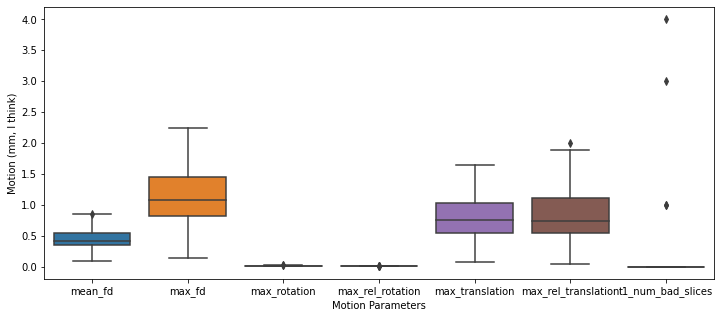

In [8]:
# Box plot of motion metrics
cleaned_df = motion_df.set_index('subject_id').drop(subs_toExclude, axis=0).reset_index()
plot_df = pd.melt(cleaned_df, id_vars = ['subject_id'])

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.boxplot(x = 'variable', y = 'value', data=plot_df, ax = ax)
ax.set_xlabel("Motion Parameters")
ax.set_ylabel("Motion (mm, I think)")

### Check significance of motion parameters to extracted data

In [9]:
from statsmodels.regression.linear_model import OLS
import seaborn as sn
import matplotlib.pyplot as plt

In [10]:
# Function to rename DWI tract data by metric

def recode_merge(metric, date_data_created):
    
    dwi_data = pd.read_csv(out_dir + '/DWI_{}_data_n=125_ZerosExcluded_{}.csv'.format(metric, date_data_merged))
    
    # Select tract data 
    tract_df = dwi_data.loc[:,"Subject":"ST_PREM_right"].set_index('Subject') 
    
    #Create column names
    if metric == 'fa0':
        colnames = 'qa_' + tract_df.columns
        tract_df.columns = colnames
    else:
        colnames = metric + '_' + tract_df.columns
        tract_df.columns = colnames

    return tract_df


In [11]:
# Drop bad subjects from dataframe
cleaned_df['Subject'] = cleaned_df['subject_id'].str.lstrip('sub-')
cleaned_df_fin = cleaned_df.drop('subject_id', axis=1)

# Recode subject column in motion df
fa_df = recode_merge('gfa', date_data_merged)
fa0_df = recode_merge('fa0', date_data_merged)
ad_df = recode_merge('ad', date_data_merged)
md_df = recode_merge('md', date_data_merged)
rd_df = recode_merge('rd', date_data_merged)

dwi_df = pd.concat([fa_df, fa0_df, ad_df, md_df, rd_df], axis=1).reset_index() # Concatenate; index is Subject
df = pd.merge(cleaned_df_fin, dwi_df, on='Subject', how = 'inner') # Merge df with motion data and df with dwi data

#Write to CSV
df.to_csv(out_dir + '/DTI_data_motion_params_n={}_{}.csv'.format(len(df), today), index=False)

In [12]:
print("File Name: '{}/DTI_data_motion_params_n={}_{}.csv".format(out_dir, len(df), today))

File Name: '/gpfs/milgram/pi/gee_dylan/candlab/analyses/shapes/dwi/QSIPrep/analysis/DTI_data_motion_params_n=119_2023-05-08.csv


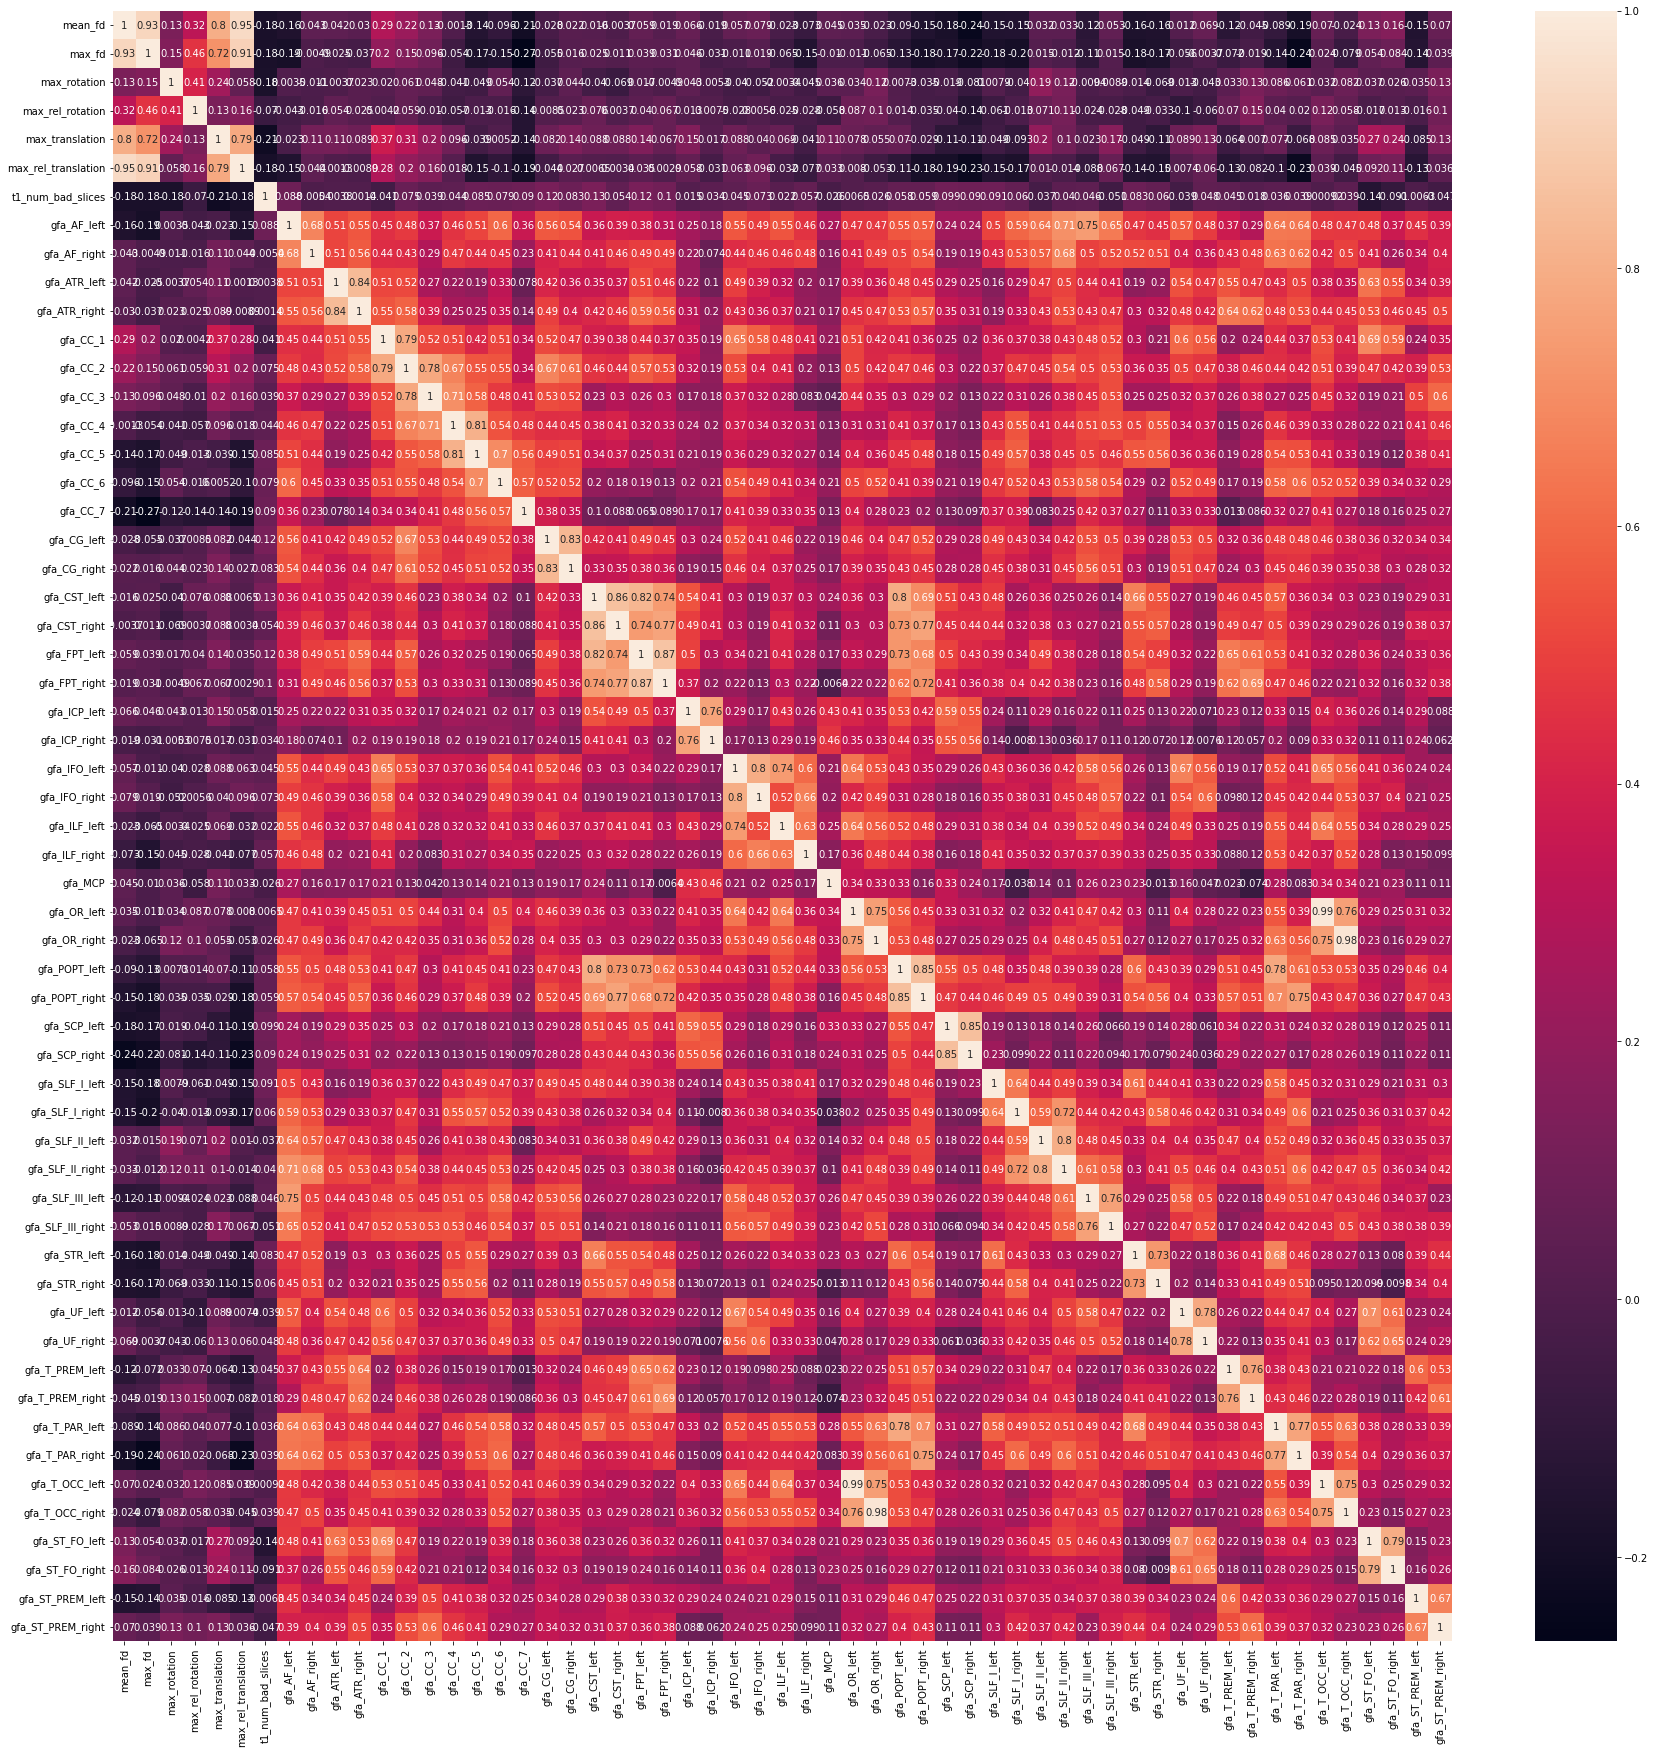

In [13]:
corrMatrix = pd.merge(cleaned_df_fin, fa_df, on='Subject', how='inner').corr()

fig, ax = plt.subplots(1, 1, figsize = (30,30))
sn.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()